In [1]:
# Supplementary figure 1

# Imports.
import matplotlib.pyplot as plt
from skimage import io
import pandas as pd
import os
import yaml
import matplotlib
import numpy as np
font = {'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42

In [2]:
# Input directories, colors & files.
data = {'+ATP': (r'figure_data/6A mutant ATP/ATP', 'tab:blue', 'darkblue')}
files = {'cpa': 'cpa_result.yaml',
         'msd': 'msd_result.yaml',
         'motion': 'summary_table.csv',
         'traces': 'filtered_traces_drift_corrected_steps-not-divided.csv'}

# CHANGE THIS PATH TO THE PATH TO THE REPOSITORY
# REPOSITORY AVAILABLE AT https//doi.org/10.4121/19948253
repository_directory = r'M:\tnw\bn\nd\Shared\Daniel\Manuscripts\2022 CMG activation paper data and analysis\RamirezMontero et al_NatComm_2023_data'

In [3]:
# Helper functions.
def dropna(arr):
    return arr[~np.isnan(arr)]

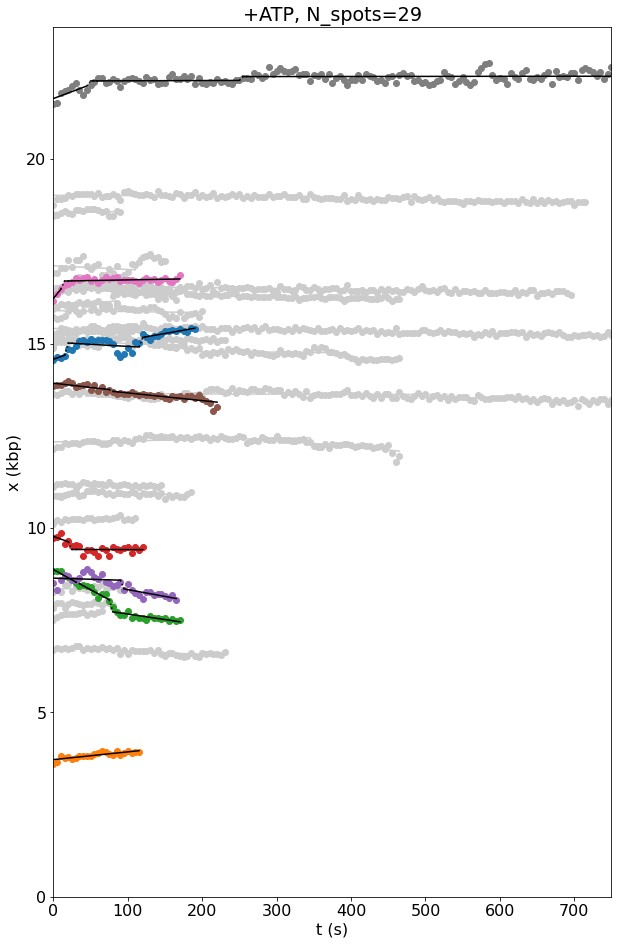

In [4]:
# Panel a

# Plot traces with CPA.
def plot_cpa(df_motion, df_traces, cpa_dict, title):
    
    N_value = []
    
    plt.figure(figsize=(10, 16))
    for scan_id, scan in df_traces.groupby('scan_id'):
        for trace_id, trace in scan.groupby('trace_id'):
            motion_data = df_motion[(df_motion['scan_id'] == scan_id) & (df_motion['trace_id'] == trace_id)].iloc[0]
            cpa_data = cpa_dict[(int(scan_id), int(trace_id))]
            moving = bool(motion_data['moving'])
            x_fit = cpa_data['x_fit']
            v = cpa_data['v_fit']
            p = cpa_data['jumps']
            if moving:
                N_value.append(1)
                plt.scatter(trace['time_s'], trace['x_kbp'], zorder=2)
                for p_index in range(len(p) - 2):
                    start = p[p_index]
                    end = p[p_index + 1]
                    plt.plot(np.array(trace['time_s'])[start:end], x_fit[start:end], zorder=2, c='k')
                    plt.plot(np.array(trace['time_s'])[end - 1:end + 3], x_fit[end - 1:end + 3], zorder=2, c='k',
                             linestyle='dotted')
                plt.plot(np.array(trace['time_s'])[p[-2]:p[-1]], x_fit[p[-2]:p[-1]], zorder=2, c='k')
            else:
                N_value.append(1)
                plt.scatter(trace['time_s'], trace['x_kbp'], color=(0.8, 0.8, 0.8, 1), zorder=1)
                for p_index in range(len(p) - 2):
                    start = p[p_index]
                    end = p[p_index + 1]
                    plt.plot(np.array(trace['time_s'])[start:end], x_fit[start:end], color=(0.8, 0.8, 0.8, 1), zorder=1)
                    plt.plot(np.array(trace['time_s'])[end - 1:end + 3], x_fit[end - 1:end + 3],
                             color=(0.8, 0.8, 0.8, 1), zorder=1, linestyle='dotted')
                plt.plot(np.array(trace['time_s'])[p[-2]:p[-1]], x_fit[p[-2]:p[-1]], color=(0.8, 0.8, 0.8, 1), zorder=1)    
    plt.title(title + ", N_spots="+str(len(N_value)))
    plt.ylim(0, df_traces['dna_length_kbp'].iloc[0])
    plt.ylabel('x (kbp)')
    plt.xlabel('t (s)')
    plt.xlim(0, 750)
    plt.show()
    plt.close()            
    

for name, params in data.items():
    df_motion = pd.read_csv(os.path.join(params[0], files['motion']))
    df_traces = pd.read_csv(os.path.join(params[0], files['traces']))
    with open(os.path.join(params[0], files['cpa'])) as file:
        cpa_dict = yaml.load(file, Loader=yaml.FullLoader)
    plot_cpa(df_motion, df_traces, cpa_dict, name)

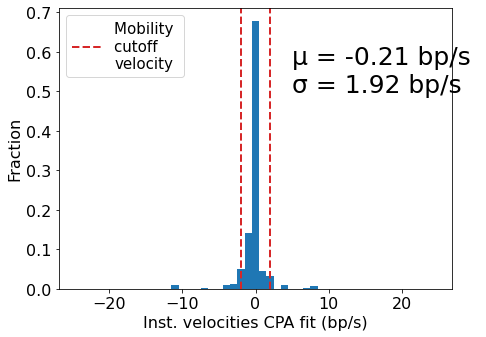

In [5]:
# Panel e

cpa_v_threshold_dcas9 = 0.4 * 5

def plot_cpa_velocity_all(df_motion, cpa_dict, title, color, edgecolor, ax=None, text='inside'):
    
    v_all = np.array([])
    v_static = np.array([])
    abs_mean_v = []
    abs_mean_v_nonstatic = []
    all_abs_v_nonstatic = []
    abs_mean_v_static = []
    v_weight = []
    v_weight_nonstatic = []
    v_weight_static = []
    
    for key, cpa_data in cpa_dict.items():
        v_all = np.concatenate((v_all, cpa_data['v_fit']))
        scan_id, trace_id = key
        motion_data = df_motion[(df_motion['scan_id'] == scan_id) & (df_motion['trace_id'] == trace_id)].iloc[0]
        abs_mean_v.append(np.absolute(np.mean(cpa_data['v_fit'])))
        v_weight.append(len(cpa_data['v_fit']))
        if bool(motion_data['moving']):
            abs_mean_v_nonstatic.append(np.absolute(np.mean(cpa_data['v_fit'])))
            v_weight_nonstatic.append(len(cpa_data['v_fit']))
            all_abs_v_nonstatic = all_abs_v_nonstatic + [abs_mean_v_nonstatic[-1] for _ in range(v_weight_nonstatic[-1])]
        else:
            v_static = np.concatenate((v_static, cpa_data['v_fit']))
            abs_mean_v_static.append(np.absolute(np.mean(cpa_data['v_fit'])))
            v_weight_static.append(len(cpa_data['v_fit']))
    
    v_bins = np.array([i for i in np.arange(-24.5, 25.5, 1)])
    if ax is None:
        fig, ax = plt.subplots()
    ax.hist(1000*v_all, bins=v_bins, weights=[1/len(v_all) for _ in v_all], 
            color=color, linewidth=0)
    ax.set_ylabel('Fraction')
    ax.set_xlabel('Inst. velocities CPA fit (bp/s)')
    ax.set_xticks([-20, -10, 0, 10, 20])
    ax.axvline(cpa_v_threshold_dcas9, color='tab:red', linestyle='dashed', linewidth=2)
    ax.axvline(-cpa_v_threshold_dcas9, color='tab:red', linestyle='dashed', linewidth=2)
    if text == 'inside':
        ax.legend(['Mobility \ncutoff \nvelocity'], loc='upper left', fontsize=15)
        ax.text(5, ax.get_ylim()[1]*0.7, "μ = %.2f bp/s \nσ = %.2f bp/s" % (1000*np.mean(v_all), 1000 * np.std(v_all)), fontsize=25)
    elif text == 'above':
        ax.legend(['Mobility \ncutoff \nvelocity'], loc='upper left', fontsize=15)
        ax.text(0, ax.get_ylim()[1]*1.1, "μ = %.2f bp/s \nσ = %.2f bp/s" % (1000*np.mean(v_all), 1000 * np.std(v_all)), 
                fontsize=25, horizontalalignment='center')
    if ax is None:
        plt.title(title + ", non-static traces")
        plt.show()
        plt.close()


fig = plt.figure(figsize=(24, 30))
gs = matplotlib.gridspec.GridSpec(5, 3)

# Get data
name0 = '+ATP'
params0 = data[name0]
df0 = pd.read_csv(os.path.join(params0[0], files['motion']))
with open(os.path.join(params0[0], files['cpa'])) as file:
    cpa_dict0 = yaml.load(file, Loader=yaml.FullLoader)
    
# Panel A
ax1 = fig.add_subplot(gs[0, 0])
plot_cpa_velocity_all(df0, cpa_dict0, name0, params0[1], params0[2], ax1)


0 / 29  uncategorized
[0.72413793 0.03448276 0.10344828 0.13793103] [0.08299609 0.03388301 0.0565523  0.06403288]


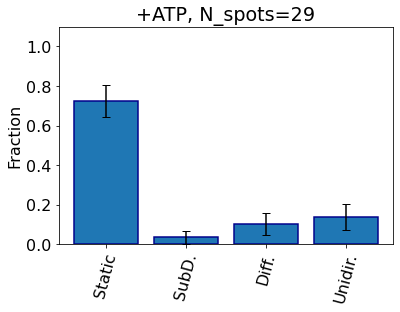

In [6]:
# Panel f

def plot_motion_type_histogram(df_motion, title, color, edgecolor):
    
    anom_diff_D = np.array(df_motion['anomalous diffusion'])
    anom_diff_exp = np.array(df_motion['alpha'])
    moving_list = np.array(df_motion['moving'], dtype=bool)

    anom_diff_exp_m = anom_diff_exp[moving_list]
    static = len(moving_list[~moving_list])
    subD = len(anom_diff_exp_m[anom_diff_exp_m < 0.5])
    diffD = len(anom_diff_exp_m[(anom_diff_exp_m >= 0.5) & (anom_diff_exp_m < 1.5)])
    superD = len(anom_diff_exp_m[anom_diff_exp_m >= 1.5])
    n = static + subD + diffD + superD
    n_nan = len(moving_list) - n

    x = [0, 1, 2, 3]
    y = np.array([static / n,
                  subD / n,
                  diffD / n,
                  superD / n])
    yerr = np.sqrt(y * (1 - y) / n)
    print(n_nan, '/', len(moving_list), ' uncategorized')
    print(y, yerr)

    plt.figure()
    plt.bar(x, y, color=color, yerr=yerr, edgecolor=edgecolor, linewidth=1.5, capsize=4)
    plt.xticks([0, 1, 2, 3], ['Static', 'SubD.', 'Diff.', 'Unidir.'], rotation=75)
    plt.title(title + ", N_spots=" + str(len(moving_list)))
    plt.ylabel('Fraction')
    plt.ylim(0, 1.1)
    plt.show()
    plt.close()
    
for name, params in data.items():
    df_motion = pd.read_csv(os.path.join(params[0], files['motion']))
    plot_motion_type_histogram(df_motion, name, params[1], params[2])

Text(0.5, 0, 'Initial position from DNA center (kbp)')

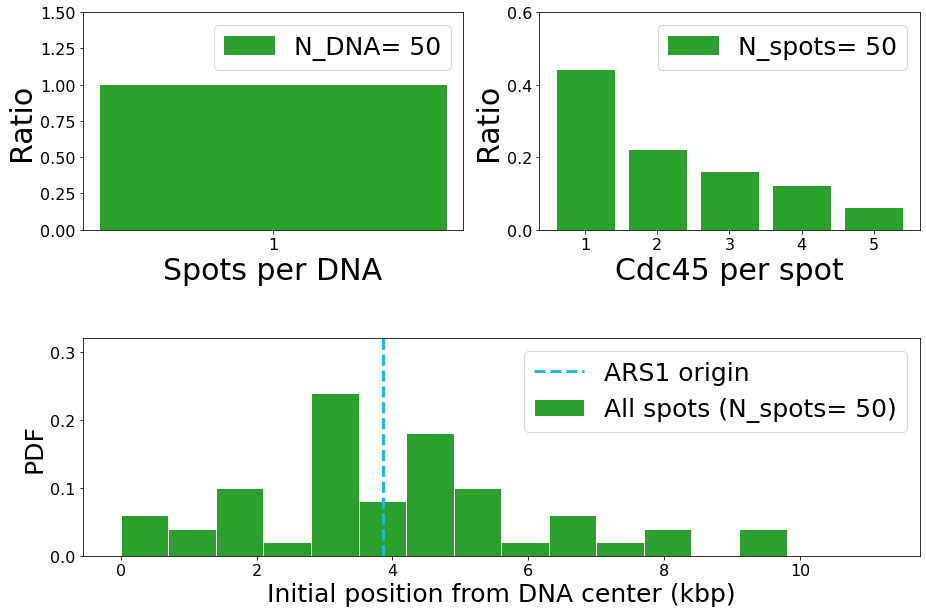

In [7]:
# Panel B

# File locations

ATP_data = os.path.join(repository_directory, r'Raw single-molecule data\Single color experiments\6A mutant CMG\C_6A ATP.csv')

facecolor='tab:green'
edgecolor='white'

# Open files

df_ATP= pd.read_csv(ATP_data)


# General filters

DNA_len_kbp=23.582 # Set DNA lenght (kbp)
dist_from_beads=1 # Set distance (kbp) from beads for filtering
N_frames_to_average=3 # set how many frames to average for initial position plots
max_initial_frame=3 # set maximum frame number at which a trace can start


# Set bin width in kbp
binsize=0.70
bins=np.arange(0, DNA_len_kbp/2, binsize)


# Filter by stoichiometry
min_stoich=1 # set minimum stoichiometry allowed
max_stoich=5 # set maximum stoichiometry allowed

df_ATP_filtered = df_ATP.loc[df_ATP['step_count']>=min_stoich].copy()
df_ATP_filtered = df_ATP_filtered.loc[df_ATP_filtered['step_count']<=max_stoich].copy()
df_ATP_filtered = df_ATP_filtered[~df_ATP_filtered['step_count'].isna()]


# Get spots per dna and stoichiometry per DNA (after filtering) ALL CONDITIONS

spots_per_DNA = [] # list of spot/DNA, sum of all stoichs for each DNA
stoichiometries=[] # list of all stoichiometrie of all the spots

for scan_id, df_scan in df_ATP_filtered.groupby('scan_id'):
    spots_this_DNA=[]
    stoichiometries_this_DNA=[]
    for trace_id, df_trace in df_scan.groupby('trace_id'):
        if df_trace['step_count'].iloc[0]>0 and df_trace['frame'].iloc[0]<=(max_initial_frame-1) and df_trace['x_kbp'].iloc[0] > dist_from_beads and df_trace['x_kbp'].iloc[0] < DNA_len_kbp-dist_from_beads:
            spots_this_DNA.append(1)
            stoich_this_spot=[df_trace['step_count'].iloc[0]]
            stoichiometries_this_DNA.extend(stoich_this_spot)
            stoichiometries.extend(stoich_this_spot)
    stoichiometries_this_DNA.sort()          
    total_spots_DNA=np.sum(spots_this_DNA)
    sum_stoichs_this_DNA=np.sum(stoichiometries_this_DNA)
    spots_per_DNA.append((total_spots_DNA, sum_stoichs_this_DNA))
    

#Convert spots per DNA to string and plot spot counts

spots_per_DNA_array = np.array([tup[0] for tup in spots_per_DNA])
spots_per_DNA_array=spots_per_DNA_array[spots_per_DNA_array>0]



fig = plt.figure(figsize=(15, 10))
gs = matplotlib.gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.5)


ax1 = fig.add_subplot(gs[0, 0])



labels, counts = np.unique(spots_per_DNA_array, return_counts=True)
ax1.bar(labels, counts/len(spots_per_DNA_array), facecolor=facecolor, edgecolor=facecolor)
ax1.set_ylabel('Ratio', fontsize=30)
ax1.set_xlabel('Spots per DNA', fontsize=30)
ax1.set_ylim(0, 1.5)
ax1.set_xticks(np.arange(1,np.max(spots_per_DNA_array)+1,1))
ax1.legend(['N_DNA= '+str(len(spots_per_DNA_array))], loc='upper right', fontsize=25)


# Panel c

ax2 = fig.add_subplot(gs[0, 1])

#Plot stoichiometries
labels, counts = np.unique(stoichiometries, return_counts=True)
ax2.bar(labels, counts/len(stoichiometries), facecolor=facecolor, edgecolor=facecolor)
ax2.set_ylabel('Ratio', fontsize=30)
ax2.set_xlabel('Cdc45 per spot', fontsize=30)
ax2.set_ylim(0, 0.6)
ax2.set_xticks(np.arange(1,np.max(stoichiometries)+1,1))
ax2.set_yticks(np.arange(0, 0.7, 0.20))
plt.tick_params(axis='x')
plt.tick_params(axis='y')
ax2.legend(['N_spots= '+str(len(stoichiometries))], loc='upper right', fontsize=25)

# Panel d

# Get average position of first 3 frames after filtering spots appearing after a given frame

initial_locs= []

for scan_id, df_scan in df_ATP_filtered.groupby('scan_id'):
    for trace_id, df_trace in df_scan.groupby('trace_id'):
        if df_trace['step_count'].iloc[0]>0 and df_trace['frame'].iloc[0]<=(max_initial_frame-1) and df_trace['x_kbp'].iloc[0] > dist_from_beads and df_trace['x_kbp'].iloc[0] < DNA_len_kbp-dist_from_beads:
            init_loc = [np.mean(df_trace['x_kbp'].iloc[0:(N_frames_to_average-1)])]
            initial_locs.append(init_loc)


initial_locs_np= np.array(initial_locs)
locs_from_center= abs(initial_locs_np-(DNA_len_kbp/2))


# Plot initial positions histogram of all spots

ax3 = fig.add_subplot(gs[1, 0:2])
weights=np.zeros_like(locs_from_center)+1./locs_from_center.size
ax3.hist(locs_from_center, bins=bins, weights=weights, range=(0, DNA_len_kbp/2), edgecolor=edgecolor, facecolor=facecolor)
ax3.set_ylabel('PDF', fontsize=25)
ax3.set_ylim(0, 0.32)
ax3.set_xticks(np.arange(0,DNA_len_kbp/2,2))
ax3.set_yticks(np.arange(0, 0.32, 0.1))
ax3.axvline(3.860, color='tab:cyan', linestyle='dashed', linewidth=3) # Highlight origin
ax3.legend(['ARS1 origin','All spots (N_spots= '+str(len(locs_from_center))+')'], loc='upper right', fontsize=25)
ax3.set_xlabel(r'Initial position from DNA center (kbp)', fontsize=25)


<function matplotlib.pyplot.show(close=None, block=None)>

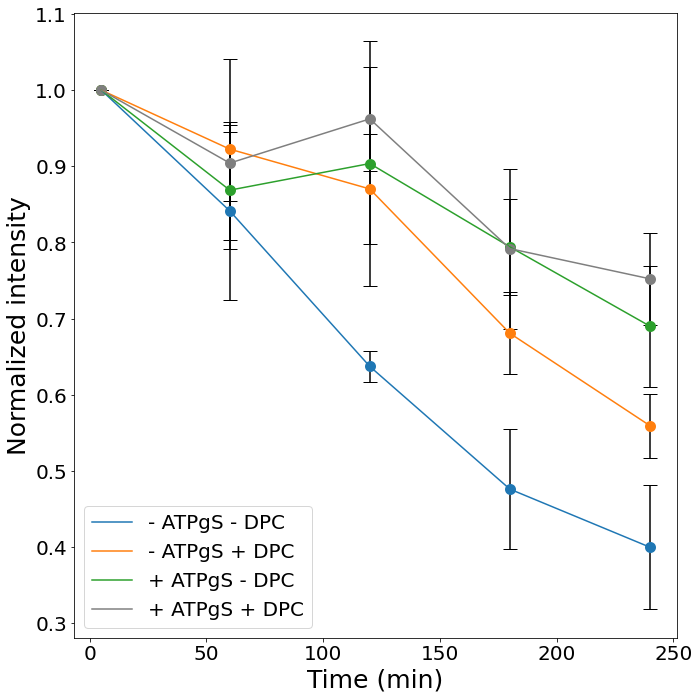

In [8]:
# Panel h

# File locations.
densitometries_path = os.path.join(repository_directory, r'Raw bulk data\Protein gels\Supplementary Fig. 9g-h\Densitometry all gels.csv')

# Open files.
df_densitometries = pd.read_csv(densitometries_path)

# Get values and calculate statistics

sample_means_std=[]
for sample, df_sample_number in df_densitometries.groupby('Sample'):
    for timepoint, df_timepoint in df_sample_number.groupby('Time (min)'): 
        time=timepoint
        avg=np.mean(df_timepoint['Normalized to 5 min'])
        st_dev=np.std(df_timepoint['Normalized to 5 min'])
        sample_means_std.append([sample, time, avg, st_dev])

sample_means_std_np=np.array(sample_means_std)


plt.figure(figsize=(10, 10))

plt.scatter(sample_means_std_np[0:5,1],sample_means_std_np[0:5,2], color='tab:blue', linewidth=5, zorder=2)
plt.scatter(sample_means_std_np[5:10,1],sample_means_std_np[5:10,2], color='tab:orange', linewidth=5, zorder=2)
plt.scatter(sample_means_std_np[10:15,1],sample_means_std_np[10:15,2], color='tab:green', linewidth=5, zorder=2)
plt.scatter(sample_means_std_np[15:20,1],sample_means_std_np[15:20,2], color='tab:gray', linewidth=5, zorder=2)


plt.errorbar(sample_means_std_np[0:5,1],sample_means_std_np[0:5,2], yerr=sample_means_std_np[0:5,3], capsize=7, fmt='o', color='black', zorder=1)
plt.errorbar(sample_means_std_np[5:10,1],sample_means_std_np[5:10,2], yerr=sample_means_std_np[5:10,3],capsize=7, fmt='o', color='black', zorder=1)
plt.errorbar(sample_means_std_np[10:15,1],sample_means_std_np[10:15,2], yerr=sample_means_std_np[10:15,3], capsize=7, fmt='o',  color='black', zorder=1)
plt.errorbar(sample_means_std_np[15:20,1],sample_means_std_np[15:20,2], yerr=sample_means_std_np[15:20,3], capsize=7, fmt='o', color='black', zorder=1)

plt.plot(sample_means_std_np[0:5,1],sample_means_std_np[0:5,2], color='tab:blue')
plt.plot(sample_means_std_np[5:10,1],sample_means_std_np[5:10,2], color='tab:orange')
plt.plot(sample_means_std_np[10:15,1],sample_means_std_np[10:15,2], color='tab:green')
plt.plot(sample_means_std_np[15:20,1],sample_means_std_np[15:20,2], color='tab:gray')

    
plt.legend(['- ATPgS - DPC','- ATPgS + DPC','+ ATPgS - DPC','+ ATPgS + DPC'], fontsize=20)
plt.xlabel('Time (min)', size=25)
plt.ylabel('Normalized intensity', size=25)
plt.xticks(size=20)
plt.yticks(size=20)

plt.tight_layout()
plt.show
